In [1]:
import numpy as np
import pandas as pd
from surprise import Dataset, NormalPredictor, Reader, SVD, accuracy, Trainset

In [2]:
ratings_set_df = pd.read_csv("./data_movie_lens_100k/ratings_all_development_set.csv")
users_df = pd.read_csv("./data_movie_lens_100k/user_info.csv")
movies_df = pd.read_csv("./data_movie_lens_100k/movie_info.csv")

In [3]:
print(ratings_set_df)
print(users_df)
#print(movies_df)

       user_id  item_id  rating
0          772       36       3
1          471      228       5
2          641      401       4
3          312       98       4
4           58      504       5
...        ...      ...     ...
89987      415      813       4
89988      842      120       3
89989      574      505       2
89990      757      472       5
89991      503      204       3

[89992 rows x 3 columns]
     user_id  age  is_male  orig_user_id
0          0   24        1             1
1          1   53        0             2
2          2   23        1             3
3          3   24        1             4
4          4   33        0             5
..       ...  ...      ...           ...
938      938   26        0           939
939      939   32        1           940
940      940   20        1           941
941      941   48        0           942
942      942   22        1           943

[943 rows x 4 columns]


In [4]:
from sklearn.model_selection import train_test_split

ratings_features = ratings_set_df[["user_id", "item_id"]]
ratings = ratings_set_df["rating"]
X_train, X_test, y_train, y_test = train_test_split(ratings_features, ratings)

In [18]:
from train_valid_test_loader import load_train_valid_test_datasets

# Load the dataset in the same way as the main problem 
train_tuple, valid_tuple, test_tuple, n_users, n_items = \
        load_train_valid_test_datasets()


def tuple_to_surprise_dataset(tupl):
    """
    This function convert a subset in the tuple form to a `surprise` dataset. 
    """
    ratings_dict = {
        "userID": tupl[0],
        "itemID": tupl[1],
        "rating": tupl[2],
    }

    df = pd.DataFrame(ratings_dict)

    # A reader is still needed but only the rating_scale param is requiered.
    reader = Reader(rating_scale=(1, 5))

    # The columns must correspond to user id, item id and ratings (in that order).
    dataset = Dataset.load_from_df(df[["userID", "itemID", "rating"]], reader)

    return dataset

## Below we train an SVD model and get its vectors 

# train an SVD model using the training set
trainset = tuple_to_surprise_dataset(train_tuple).build_full_trainset()
test_trainset = tuple_to_surprise_dataset(test_tuple).build_full_trainset()

In [59]:


from sklearn.preprocessing import StandardScaler

def get_features_for_user(user_id):
    return np.array(users_df[users_df["user_id"] == user_id].iloc[0][["age", "is_male"]])

def get_features_for_item(item_id):
    return np.array(movies_df[movies_df["item_id"] == item_id].iloc[0][["release_year"]])

def get_rating(user_id, item_id, features_df: pd.DataFrame):
    return features_df[
        (features_df["user_id"] == user_id) &
            (features_df["item_id"] == item_id)
    ].iloc[0]["rating"]

def get_feature_vectors(data_tuple, svd: SVD, trainset: Trainset):
    user_vectors = svd.pu
    item_vectors = svd.qi
    
    features = np.zeros(
        (
            len(data_tuple[0]),
            user_vectors.shape[1] + item_vectors.shape[1] + len(["age", "is_male"]) + len(["release_year"])
        )
    )
    ratings = []
    for index in range(0, len(data_tuple[0])):
        user_id = data_tuple[0][index]
        item_id = data_tuple[1][index]
        try:
            u_i = user_vectors[trainset.to_inner_uid(user_id)]
        except:
            u_i = np.zeros((user_vectors.shape[1]))
        try:
            m_j = item_vectors[trainset.to_inner_iid(item_id)]
        except:
            m_j = np.zeros((item_vectors.shape[1]))
        # if trainset.knows_user(user_id):
        #     u_i = user_vectors[trainset.to_inner_uid(user_id)]
        # m_j = np.zeros((item_vectors.shape[1]))
        # if trainset.knows_item(item_id):
        #     m_j = item_vectors[trainset.to_inner_iid(item_id)]
        user_features = get_features_for_user(user_id)
        item_features = get_features_for_item(item_id)
        feature_vector = np.concatenate(
            (
                u_i,
                m_j,
                user_features,
                item_features,
            ),
            axis=0
        )
        features[index] = feature_vector
        
        ratings.append(1 if data_tuple[2][index] > 4.5 else 0)
    
    scaler = StandardScaler()
    
    return scaler.fit_transform(features), ratings


In [60]:
svd = SVD(
    n_factors = 10,
    n_epochs=50
)

svd.fit(trainset)

features_train, ratings_train = get_feature_vectors(train_tuple, svd, trainset)
features_test, ratings_test = get_feature_vectors(test_tuple, svd, trainset)
# features_test, ratings_test = get_feature_vectors(test_tuple, svd, test_trainset)


In [28]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline, Pipeline

# mlp = MLPClassifier(
# )

# pipeline = Pipeline(steps=(
#     ('scaler', StandardScaler()),
#     ('mlp', mlp),
# ))

# param_grid = {
#     "mlp__solver": ["lbfgs", "adam", "sgd"],
#     "mlp__activation": ["relu", "tanh"],
#     "mlp__hidden_layer_sizes": [(100,), (50,)],
# }

# gs = GridSearchCV(
#     estimator=pipeline,
#     param_grid=param_grid,
#     refit=True,
#     return_train_score=True
# )

# gs.fit(features_train, ratings_train)

# print(gs.best_estimator_)



/home/thayes/miniconda3/envs/cs135_env/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/thayes/miniconda3/envs/cs135_env/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/thayes/miniconda3/envs/cs135_env/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: Conv

Pipeline(steps=[('scaler', StandardScaler()),
                ('mlp',
                 MLPClassifier(activation='tanh', hidden_layer_sizes=(50,)))])


/home/thayes/miniconda3/envs/cs135_env/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [61]:
mlp = MLPClassifier(activation='tanh', hidden_layer_sizes=(50,))

mlp.fit(features_train, ratings_train)

/home/thayes/miniconda3/envs/cs135_env/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(activation='tanh', hidden_layer_sizes=(50,))

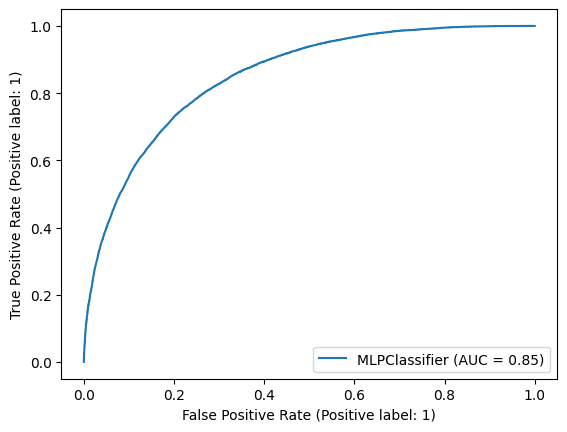

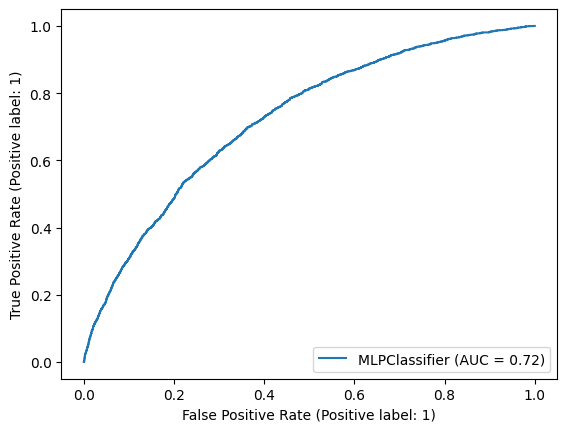

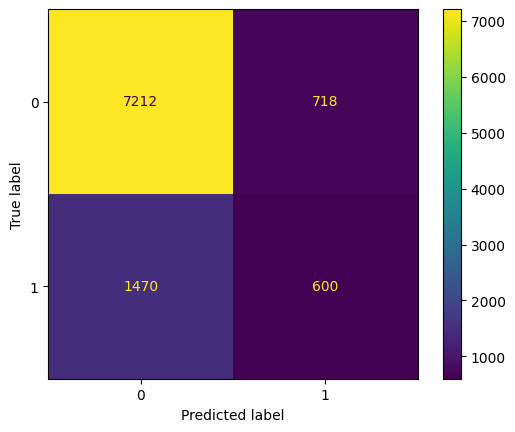

In [62]:
from sklearn.metrics import RocCurveDisplay

 
roc_disp = RocCurveDisplay.from_estimator(mlp, features_train, ratings_train)
roc_disp = RocCurveDisplay.from_estimator(mlp, features_test, ratings_test)


from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(mlp, features_test, ratings_test)

In [64]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline, Pipeline

# knn = KNeighborsClassifier()

# pipeline = Pipeline(steps=(
#     ('scaler', StandardScaler()),
#     ('knn', knn),
# ))


# param_grid = {
#     "knn__n_neighbors": [3, 5, 10],
# }

# knn_gs = GridSearchCV(
#     estimator=pipeline,
#     param_grid=param_grid,
#     refit=True,
#     return_train_score=True
# )

# knn_gs.fit(features_train, ratings_train)

knn = KNeighborsClassifier(
    leaf_size= 30,
    metric= 'minkowski',
    n_neighbors= 10,
)


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f37cad3f6d0>
Traceback (most recent call last):
  File "/home/thayes/miniconda3/envs/cs135_env/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/thayes/miniconda3/envs/cs135_env/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/thayes/miniconda3/envs/cs135_env/lib/python3.10/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/thayes/miniconda3/envs/cs135_env/lib/python3.10/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'


{'memory': None,
 'steps': [('scaler', StandardScaler()),
  ('knn', KNeighborsClassifier(n_neighbors=10))],
 'verbose': False,
 'scaler': StandardScaler(),
 'knn': KNeighborsClassifier(n_neighbors=10),
 'scaler__copy': True,
 'scaler__with_mean': True,
 'scaler__with_std': True,
 'knn__algorithm': 'auto',
 'knn__leaf_size': 30,
 'knn__metric': 'minkowski',
 'knn__metric_params': None,
 'knn__n_jobs': None,
 'knn__n_neighbors': 10,
 'knn__p': 2,
 'knn__weights': 'uniform'}

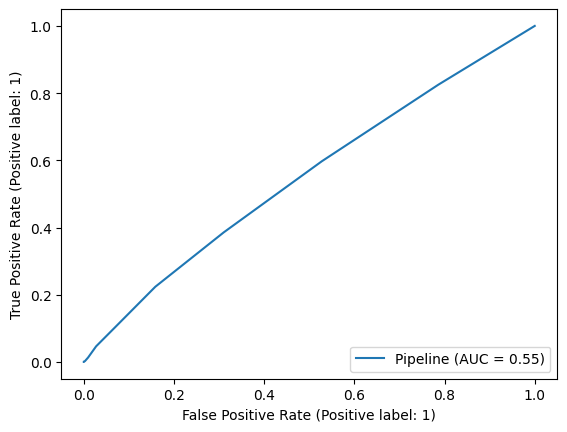

In [63]:
from sklearn.metrics import RocCurveDisplay

 
roc_disp = RocCurveDisplay.from_estimator(knn_gs.best_estimator_, features_test, ratings_test)
knn_gs.best_estimator_.get_params()

In [40]:
from sklearn.linear_model import LogisticRegression
lr_param_grid = {
    "penalty": ["l1", "l2"],
    "C": [0.01, 0.05, 0.1, 0.5, 1],
    "solver": ["lbfgs", "liblinear"],
}

lr_gs = GridSearchCV(
    estimator=LogisticRegression(),
    param_grid=lr_param_grid,
    refit=True,
    return_train_score=True
)

lr_gs.fit(features_train, ratings_train)
print(lr_gs.best_estimator_)

LogisticRegression(C=0.01, penalty='l1', solver='liblinear')


/home/thayes/miniconda3/envs/cs135_env/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
25 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
25 fits failed with the following error:
Traceback (most recent call last):
  File "/home/thayes/miniconda3/envs/cs135_env/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/thayes/miniconda3/envs/cs135_env/lib/python3.10/site-packages/sklearn/base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/home/thayes/miniconda3/envs/cs135_env/lib/python3.10/site-packages/sklearn/linear_mo

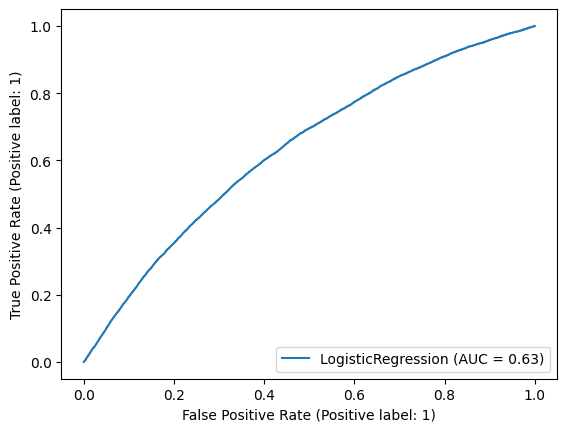

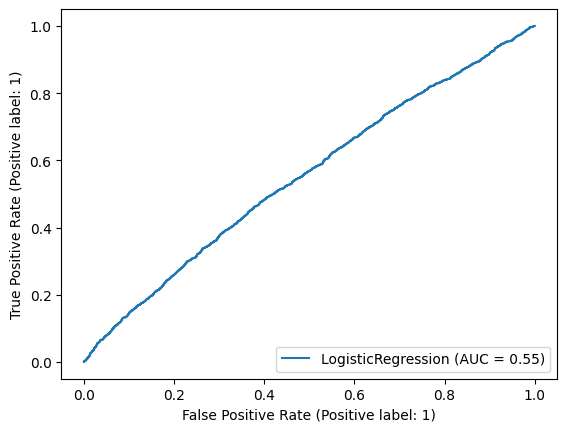

In [39]:

roc_disp = RocCurveDisplay.from_estimator(lr_gs.best_estimator_, features_train, ratings_train)
roc_disp = RocCurveDisplay.from_estimator(lr_gs.best_estimator_, features_test, ratings_test)

In [57]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

ab_gs_params = {
    "algorithm": ["SAMME", "SAMME.R"],
    "n_estimators": [50, 100, 150],
    "learning_rate": [0.1, 0.5, 1.0, 2.0, 5.0],
    "estimator": [DecisionTreeClassifier(), LogisticRegression()],
}

ab_gs = GridSearchCV(
    estimator=AdaBoostClassifier(),
    param_grid=ab_gs_params,
)

ab_gs.fit(features_train, ratings_train)

# ab = AdaBoostClassifier(
#     algorithm="SAMME.R",
#     learning_rate=0.1,
#     n_estimators=50,
# )

# ab.fit(features_train, ratings_train)

KeyboardInterrupt: 

In [55]:
# RocCurveDisplay.from_estimator(ab_gs.best_estimator_, features_test, ratings_test)
print("estimator:", ab_gs.best_estimator_.get_params())

estimator: {'algorithm': 'SAMME.R', 'base_estimator': 'deprecated', 'estimator': None, 'learning_rate': 0.5, 'n_estimators': 150, 'random_state': None}
